In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import math
from functools import partial

from test_base import TestEigenfuncNDTorus
import bases
import eigensolvers
import functionals
import generators
import representations
import reconstructions
import utils
import otrhogonalizations

In [2]:
DEGREE = 10
N_DIM = 2
N_COL = 10**5

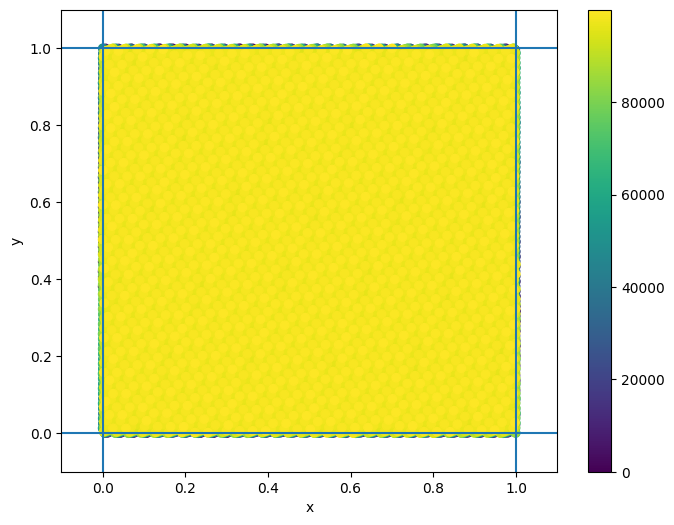

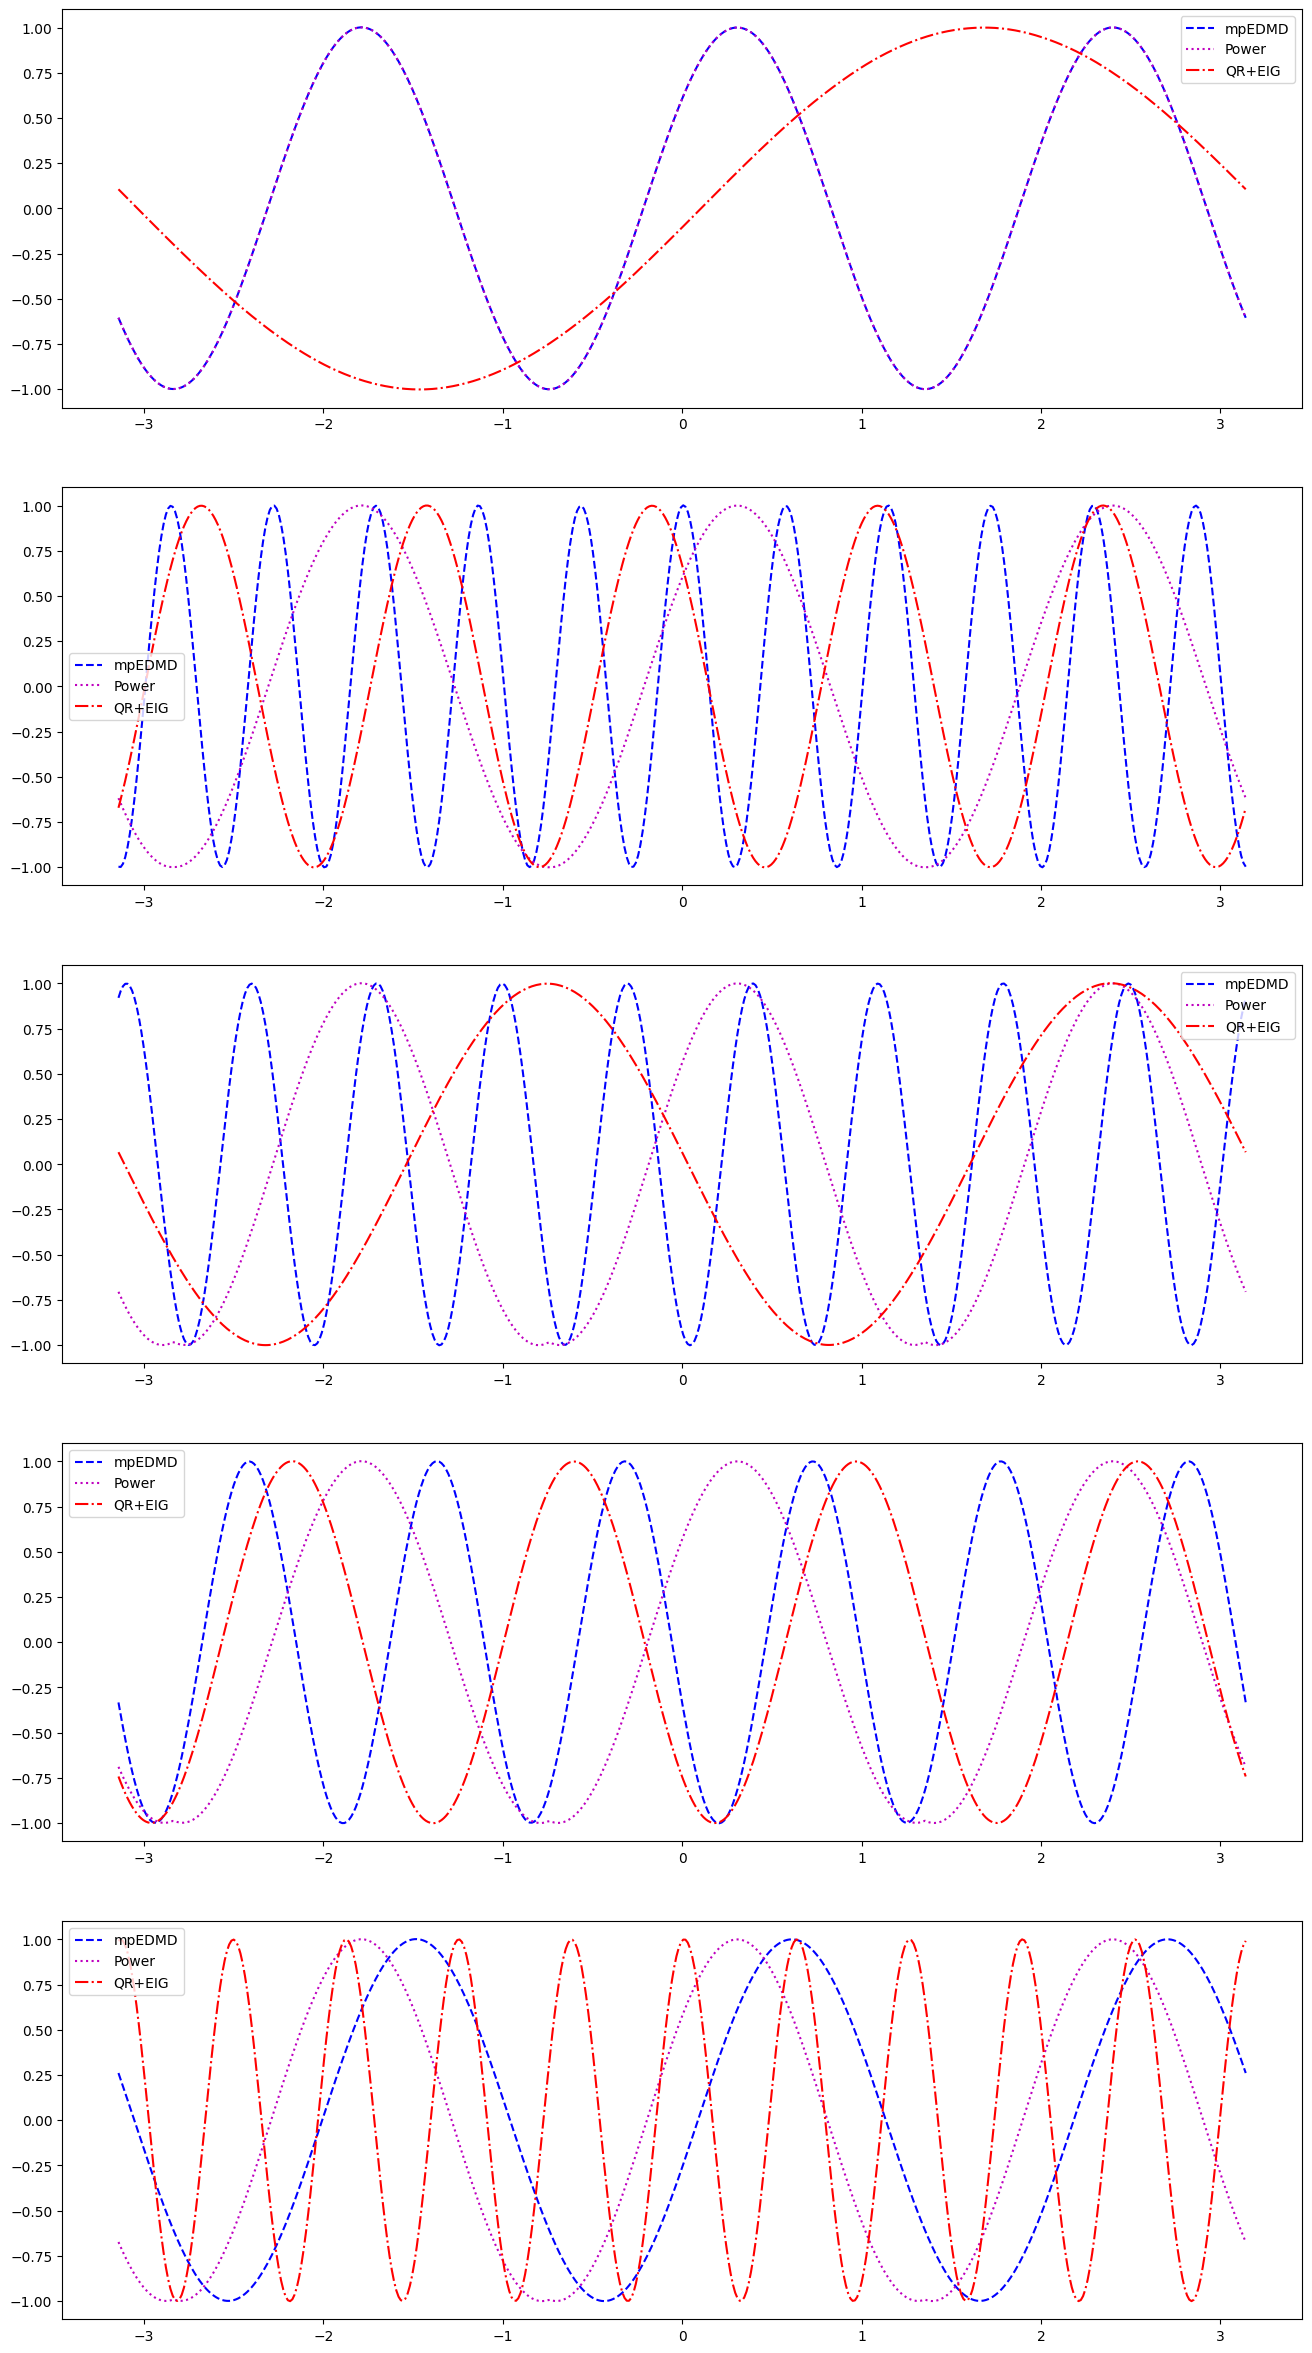

In [3]:
t = TestEigenfuncNDTorus(n_dim=N_DIM, degree=DEGREE, num_col=N_COL)
results = t.run()

In [4]:
def plot_eigenfunctions(domain, vals, n_row, labels, powers, eigenvalues):
    n_col = 1
    m = 10
    LINE_STYLES = ['b--', 'm:', 'r-.', 'g-']
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(16, 6*n_row))
    for idx in range(n_row):
        ax = axes[idx]
        for j, val in enumerate(vals):
            ax.plot(domain, val[:,m*idx].real, LINE_STYLES[j])
        ax.legend(labels)
        ax.set_title(f'power {powers[m*idx]}, eigval {utils.round_complex_number(eigenvalues[m*idx], 2)}, index {m*idx}')
    plt.show()
    return

def get_true_eigenfunction(eigenvalue, frequency):
    """
    For the the frequency w, and the eigenvalue np.exp(1j*2*pi*n*w),
    the corresponding eigenfunction should be phi(x) = np.exp(1j*2*pi*n*x).
    """
    ev_angle = np.angle(eigenvalue)  # should be 2*pi*n*w
    ef_angle = ev_angle / frequency  # should be 2*pi*n
    ef = lambda x: np.exp(1j * ef_angle * x)  # should be phi(x) = np.exp(1j*2*pi*n*x)
    return ef

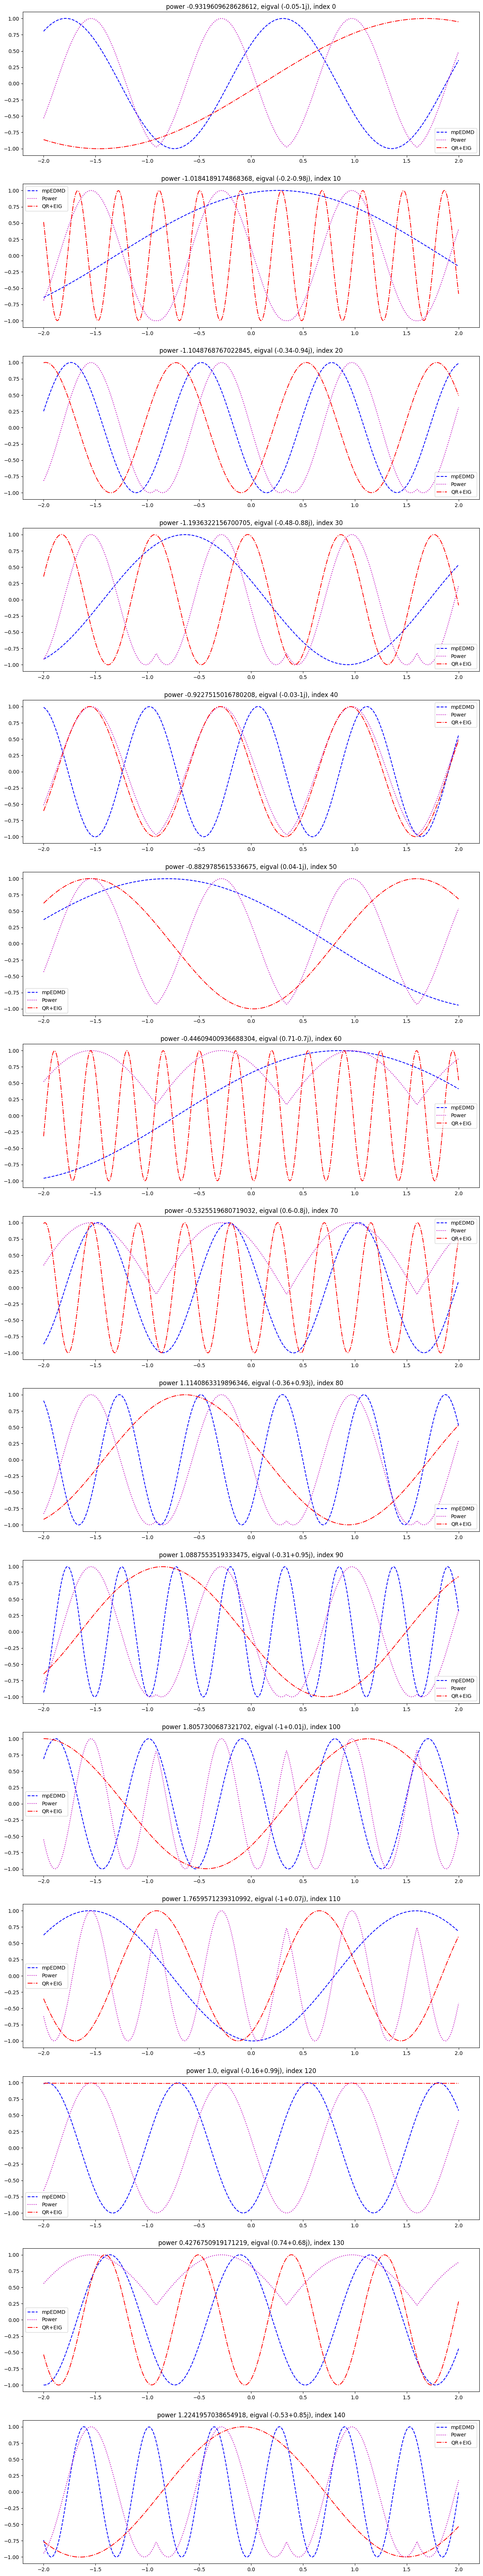

In [9]:
import eigenfunctions
from copy import deepcopy
max_range = 2
K, Vs, L, labels, n_dim, degree, frequencies = results
basis = partial(bases.fourier_basis, degree=degree, combinations=True)
domain = np.linspace([-max_range for _ in range(n_dim)], [max_range for _ in range(n_dim)], num=500)
mpPh = eigenfunctions.get_eigenfunctions_from_matrix(basis, Vs[0])
newPh = eigenfunctions.get_eigenfunctions_from_matrix(basis, Vs[1])
trPh = lambda x: np.array([get_true_eigenfunction(eig, frequencies)(x) for eig in L])
L_angles = np.angle(L)
V = Vs[0]
if abs(L_angles[0].imag) < 1e-2:
    k0 = np.argmin(abs(abs(L_angles - np.sqrt(3))))
    b = deepcopy(V[:,k0])
    v_k0, _ = eigensolvers.inverse_iteration(K, L[k0], b)
else:
    k0 = 0
    v0 = deepcopy(V[:,0])
powers = [angle/L_angles[k0] for angle in L_angles]
powPh = eigenfunctions.get_eigenfunctions_with_exponential(basis, v_k0, powers)
funcs = [mpPh, powPh, newPh]
if n_dim == 1:
    funcs += [trPh]
labels += ['True']
vals = [np.array([np.squeeze(func(d)) for d in domain]) for func in funcs]
plot_domain = domain[:,0] if domain.ndim > 1 else domain
plot_eigenfunctions(plot_domain, vals, 15, labels, powers, L)

In [6]:
def get_power_vector(v, basis, powers, r, n_dim):
    V = np.random.rand(r, r) + 1j*np.random.rand(r, r)
    V = V.astype('complex128')
    v /= np.linalg.norm(v)
    V[:,0] = v
    for i in range(1, r):
        _v = otrhogonalizations.powered_vector(v, basis, powers[i], n_dim)
        V[:,i] = _v/np.linalg.norm(_v)
    return np.sqrt(2*np.pi)*V

In [7]:
# power_V = get_power_vector(V[:,0], basis, powers, V.shape[0], n_dim)
# powvecPh = eigenfunctions.get_eigenfunctions_from_matrix(basis, power_V)
# funcs = [powPh, powvecPh]
# labels = ['naive_power', 'from_vector']
# vals = [np.array([np.squeeze(func(d)) for d in domain]) for func in funcs]
# plot_domain = domain[:,0] if domain.ndim > 1 else domain
# plot_eigenfunctions(plot_domain, vals, 10, labels, powers)